## Data Import Required Libraries

### Import Required Libraries

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, count, corr, month, year, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, DoubleType, IntegerType

### Define Schema and Import Data From Dataset

In [2]:
%%capture --no-stderr

# Create a Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the schema
custom_schema = StructType([
    StructField("Timestamp", StringType(), nullable=True),
    StructField("FromBank", IntegerType(), nullable=True),
    StructField("FromAccount", StringType(), nullable=True),
    StructField("ToBank", IntegerType(), nullable=True),
    StructField("ToAccount", StringType(), nullable=True),
    StructField("AmountReceived", DoubleType(), nullable=True),
    StructField("ReceivingCurrency", StringType(), nullable=True),
    StructField("AmountPaid", DoubleType(), nullable=True),
    StructField("PaymentCurrency", StringType(), nullable=True),
    StructField("PaymentFormat", StringType(), nullable=True),
    StructField("IsLaundering", IntegerType(), nullable=True)
])

# Load the CSV file into a DataFrame with the specified schema
file_path = "HI-Small_Trans.csv"
df = spark.read.csv(file_path, header=True, schema=custom_schema)

# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/09 22:09:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Convert string data in 'Timestamp' column to timestamp datatype

In [3]:
from pyspark.sql.functions import to_timestamp

# Assuming "timestamp_str" is the column containing the timestamp string
df = df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

# Show the DataFrame schema with the new timestamp column
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### Standardize AmountReceived and AmountPaid Columns

In [4]:
import pandas as pd

# Define the exchange rates data
exchange_rates_data = [
    {"Currency": "Yen", "ExchangeRateToUSD": 0.0069},
    {"Currency": "UK Pound", "ExchangeRateToUSD": 1.234},
    {"Currency": "Australian Dollar", "ExchangeRateToUSD": 0.704},
    {"Currency": "Saudi Riyal", "ExchangeRateToUSD": 0.267},
    {"Currency": "Mexican Peso", "ExchangeRateToUSD": 0.050},
    {"Currency": "Shekel", "ExchangeRateToUSD": 0.300},
    {"Currency": "Yuan", "ExchangeRateToUSD": 0.147},
    {"Currency": "Canadian Dollar", "ExchangeRateToUSD": 0.754},
    {"Currency": "Euro", "ExchangeRateToUSD": 1.045},
    {"Currency": "Rupee", "ExchangeRateToUSD": 0.012},
    {"Currency": "Swiss Franc", "ExchangeRateToUSD": 1.028},
    {"Currency": "US Dollar", "ExchangeRateToUSD": 1.0},
    {"Currency": "Brazil Real", "ExchangeRateToUSD": 0.191},
    {"Currency": "Bitcoin", "ExchangeRateToUSD": 16386},
    {"Currency": "Ruble", "ExchangeRateToUSD": 0.013},
]

# Create the exchange_rates_df DataFrame in Pandas
exchange_rates_df = pd.DataFrame(exchange_rates_data)


In [5]:
from pyspark.sql.functions import col

exchange_rates_df = spark.createDataFrame(exchange_rates_df)

# Assuming df is your original DataFrame
# Assuming exchange_rates_df is another DataFrame with columns Currency, ExchangeRateToUSD

# Join the original DataFrame with exchange rates DataFrame for ReceivingCurrency
df_with_receiving_rate = df.join(
    exchange_rates_df.withColumnRenamed("Currency", "RecCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "ReceivingExchangeRate"),
    col("RecCurrency") == col("ReceivingCurrency")  # Assuming the original column name in df is ReceivingCurrencyOriginal
)

# Join the resulting DataFrame with exchange rates DataFrame for PaymentCurrency
df_with_rates = df_with_receiving_rate.join(
    exchange_rates_df.withColumnRenamed("Currency", "PayCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "PaymentExchangeRate"),
    col("PayCurrency") == col("PaymentCurrency")  # Assuming the original column name in df is PaymentCurrencyOriginal
)

# Convert AmountReceived and AmountPaid to USD based on exchange rates
currency_converted_df = df_with_rates.withColumn("AmountReceivedUSD", col("AmountReceived") * col("ReceivingExchangeRate"))
currency_converted_df = currency_converted_df.withColumn("AmountPaidUSD", col("AmountPaid") * col("PaymentExchangeRate"))

# Select the relevant columns
currency_converted_df = currency_converted_df.select("Timestamp", "FromBank", "FromAccount", "ToBank", "ToAccount",
                                                     "AmountReceived", "ReceivingCurrency", "AmountReceivedUSD",
                                                     "AmountPaid", "PaymentCurrency", "AmountPaidUSD",
                                                     "PaymentFormat", "IsLaundering")

# Show the resulting DataFrame Schema
df = currency_converted_df

df.printSchema()

/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountReceivedUSD: double (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- AmountPaidUSD: double (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



## 1. Exploratory Data Analysis

### 1.1 How many accounts are involved in Laundering?

In [6]:
# Understanding value counts in labels
df.groupBy("IsLaundering").count().show() 

+------------+-------+
|IsLaundering|  count|
+------------+-------+
|           1|   5177|
|           0|5073168|
+------------+-------+



### There are 5177 transactions involved with Laundering and 5073168 which are not.

### 1.2 On which day were highest number of transactions made?


### Representation of Laundering Transactions over Day of the Year

/tmp/ipykernel_1456/816909638.py:16: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DayOfYear", y="count", data=laundering_pandas, palette="viridis")


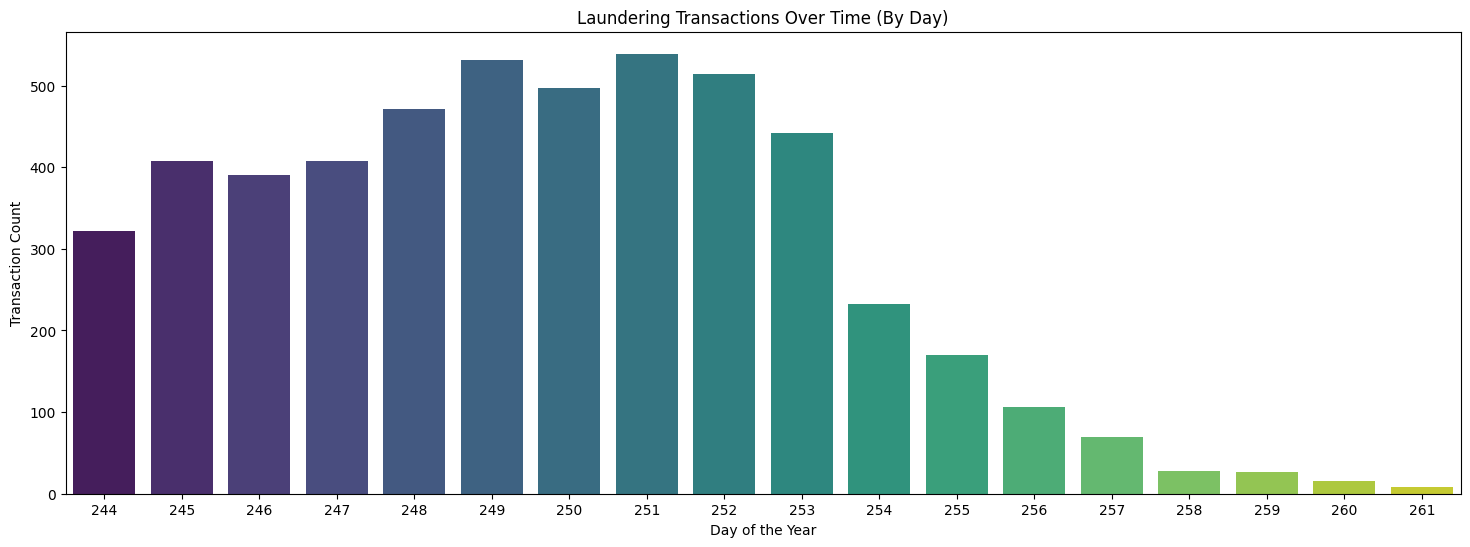

In [7]:
from pyspark.sql.functions import dayofyear
import matplotlib.pyplot as plt
import seaborn as sns

# Filter laundering transactions
laundering_df = df.filter("IsLaundering = 1")

# Group by day of the year and count the number of transactions
laundering_by_day = laundering_df.groupBy(dayofyear("Timestamp").alias("DayOfYear")).count().orderBy("DayOfYear")

# Convert Spark DataFrame to Pandas for plotting
laundering_pandas = laundering_by_day.toPandas()

# Plot using Matplotlib or Seaborn
plt.figure(figsize=(18, 6))  # Adjust the figure size based on your preference
sns.barplot(x="DayOfYear", y="count", data=laundering_pandas, palette="viridis")
plt.title("Laundering Transactions Over Time (By Day)")
plt.xlabel("Day of the Year")
plt.ylabel("Transaction Count")
plt.show()


### During which hour of the day were highest number of transactions made?


### Representation of Laundering Transactions over Hour of the Day

/tmp/ipykernel_1456/3784767582.py:16: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="HourOfDay", y="count", data=laundering_pandas, palette="viridis")


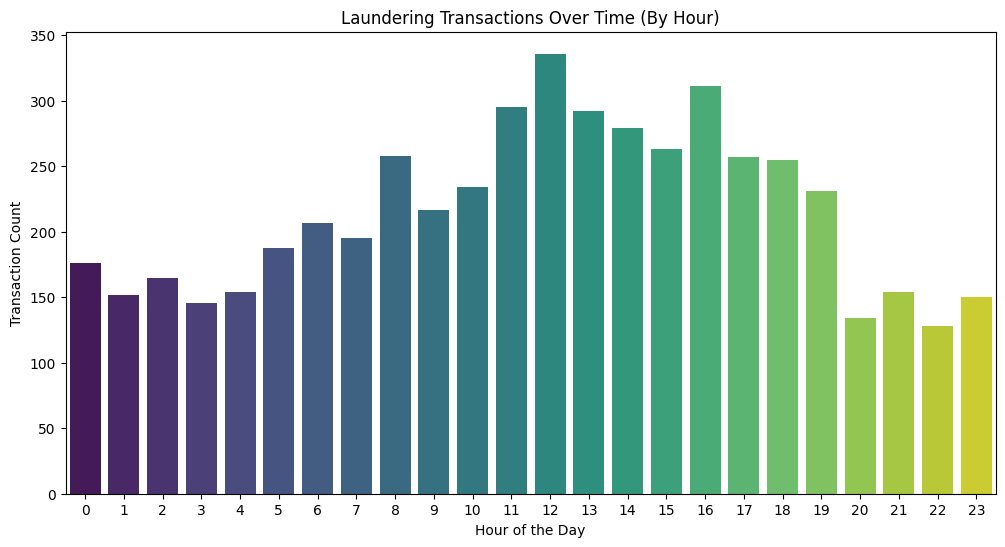

In [8]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import seaborn as sns

# Filter laundering transactions
laundering_df = df.filter("IsLaundering = 1")

# Group by hour of the day and count the number of transactions
laundering_by_hour = laundering_df.groupBy(hour("Timestamp").alias("HourOfDay")).count().orderBy("HourOfDay")

# Convert Spark DataFrame to Pandas for plotting
laundering_pandas = laundering_by_hour.toPandas()

# Plot using Matplotlib or Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="HourOfDay", y="count", data=laundering_pandas, palette="viridis")
plt.title("Laundering Transactions Over Time (By Hour)")
plt.xlabel("Hour of the Day")
plt.ylabel("Transaction Count")
plt.show()


### What is the extent of Correlation between AmountReceived and AmountPaid attributes?

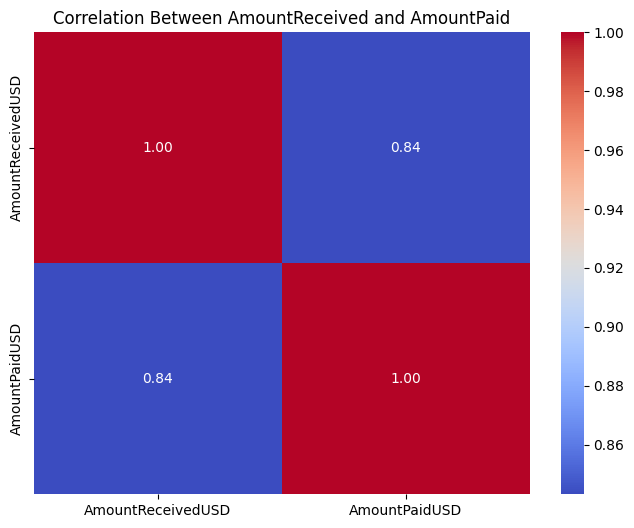

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your Spark DataFrame

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["AmountReceived", "AmountPaid"], outputCol="features")
assembled_df = assembler.transform(df)

# Calculate correlation matrix using Pandas
correlation_matrix = pd.DataFrame(assembled_df.select("features").toPandas()["features"].apply(lambda x: x.toArray()).tolist(), 
                                   columns=["AmountReceivedUSD", "AmountPaidUSD"]).corr()

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between AmountReceived and AmountPaid")
plt.show()


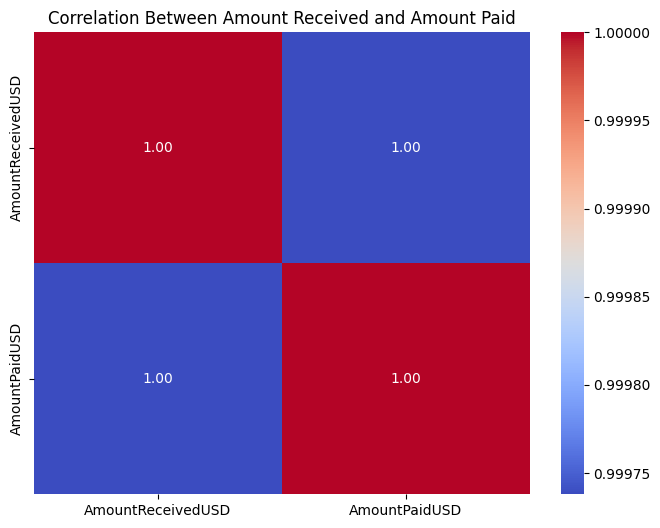

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your Spark DataFrame

# Assemble features into a vector
assembler = VectorAssembler(inputCols=["AmountReceivedUSD", "AmountPaidUSD"], outputCol="features")
assembled_df = assembler.transform(df)

# Calculate correlation matrix using Pandas
correlation_matrix = pd.DataFrame(assembled_df.select("features").toPandas()["features"].apply(lambda x: x.toArray()).tolist(), 
                                   columns=["AmountReceivedUSD", "AmountPaidUSD"]).corr()

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Amount Received and Amount Paid")
plt.show()

### 1.4 What are the top destination banks for laundered transactions?

+------+-----+
|ToBank|count|
+------+-----+
|    12|   89|
|   119|   73|
|    11|   68|
|    20|   54|
|     1|   53|
+------+-----+



/tmp/ipykernel_1456/2972378050.py:18: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="ToBank", y="count", data=top_dest_banks_pd, palette="viridis")


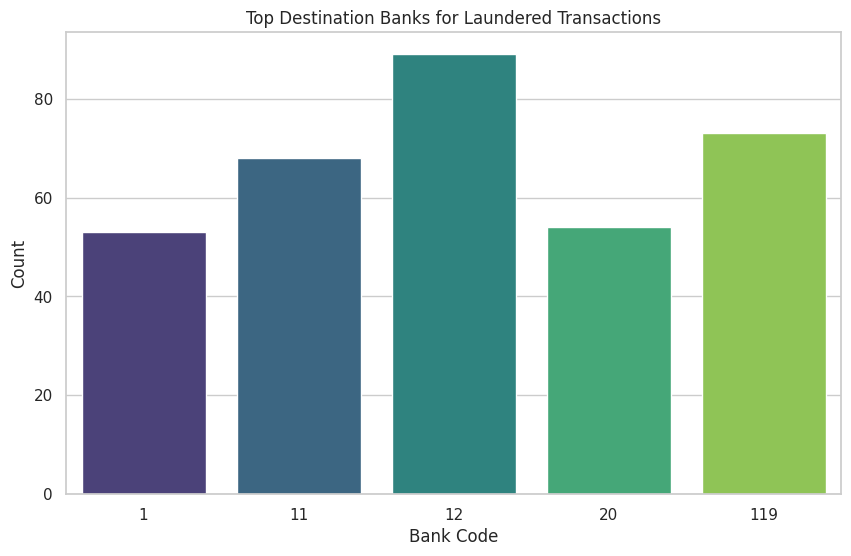

In [13]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1. Top destination banks for laundered transactions using Spark DataFrame
top_dest_banks_spark = laundering_df.groupBy("ToBank").count().sort(F.desc("count")).limit(5)

# Display the result
top_dest_banks_spark.show()

# 2. Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Convert Spark DataFrame to Pandas for Seaborn plotting
top_dest_banks_pd = top_dest_banks_spark.toPandas()

# Plot using Seaborn with x="ToBank" and y="count"
ax = sns.barplot(x="ToBank", y="count", data=top_dest_banks_pd, palette="viridis")

# Customize the plot
ax.set(xlabel="Bank Code", ylabel="Count", title="Top Destination Banks for Laundered Transactions")
plt.show()


### 1.5 What are the average transaction amount differences (in USD)?

Average difference for laundering transactions: 0.0


/tmp/ipykernel_1456/2788116980.py:22: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Transaction Type", y="Average Difference", data=diff_pd, palette="muted")


Average difference for non-laundering transactions: -1016.4529322574729


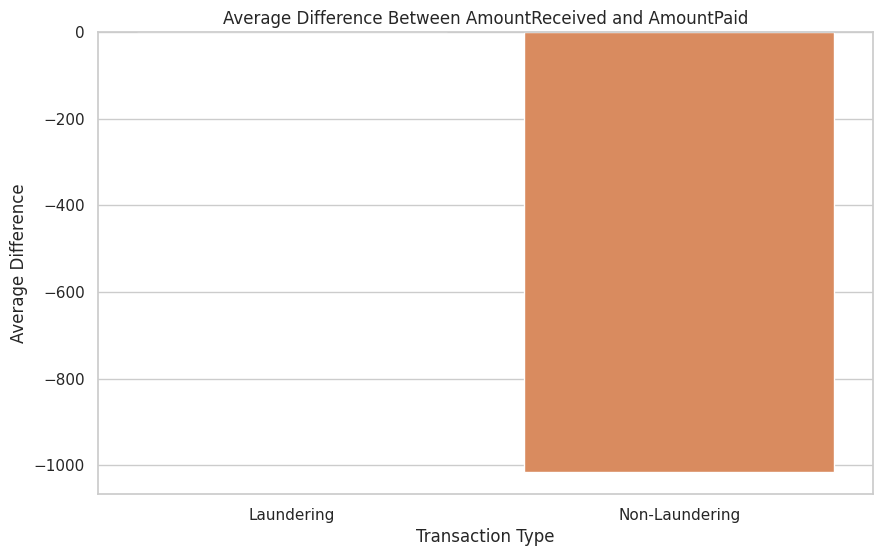

In [15]:
non_laundering_amt = df.filter("IsLaundering = 0").select("AmountReceivedUSD", "AmountPaidUSD")

# Calculate the average difference for laundering transactions using Spark DataFrame
laundering_diff_avg = laundering_df.withColumn("diff", col("AmountReceivedUSD") - col("AmountPaidUSD")).select(avg("diff")).collect()[0][0]
print(f"Average difference for laundering transactions: {laundering_diff_avg}")

# Calculate the average difference for non-laundering transactions using Spark DataFrame
non_laundering_diff_avg = non_laundering_amt.withColumn("diff", col("AmountReceivedUSD") - col("AmountPaidUSD")).select(avg("diff")).collect()[0][0]
print(f"Average difference for non-laundering transactions: {non_laundering_diff_avg}")

# Visualize using Seaborn
plt.figure(figsize=(10, 6))

# Create a DataFrame for Seaborn
diff_data = [("Laundering", laundering_diff_avg), ("Non-Laundering", non_laundering_diff_avg)]
diff_df = spark.createDataFrame(diff_data, ["Transaction Type", "Average Difference"])

# Convert to Pandas for Seaborn plotting
diff_pd = diff_df.toPandas()

# Plot using Seaborn
ax = sns.barplot(x="Transaction Type", y="Average Difference", data=diff_pd, palette="muted")

# Customize the plot
ax.set(xlabel="Transaction Type", ylabel="Average Difference", title="Average Difference Between AmountReceived and AmountPaid")
plt.show()


### Average difference for laundering transactions: 0.0 and Average difference for non-laundering transactions:  ~ -1016.45



### 1.6 What are the top currencies of laundered transactions?

+---------------+-----+
|PaymentCurrency|count|
+---------------+-----+
|      US Dollar| 1912|
|           Euro| 1372|
|    Saudi Riyal|  374|
|    Swiss Franc|  193|
|           Yuan|  184|
+---------------+-----+



/tmp/ipykernel_1456/1267996108.py:18: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="PaymentCurrency", y="count", data=top_currencies_pd, palette="muted")


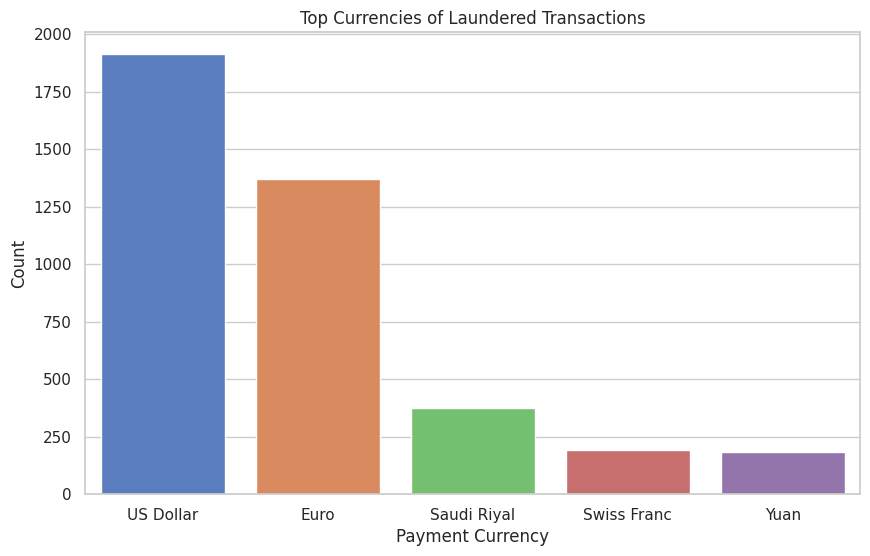

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Find the top currencies for laundered transactions using Spark DataFrame
top_currencies_spark = laundering_df.groupBy("PaymentCurrency").count().sort(F.desc("count")).limit(5)

# Display the result
top_currencies_spark.show()

# Visualize using Seaborn
plt.figure(figsize=(10, 6))

# Convert Spark DataFrame to Pandas for Seaborn plotting
top_currencies_pd = top_currencies_spark.toPandas()

# Plot using Seaborn
ax = sns.barplot(x="PaymentCurrency", y="count", data=top_currencies_pd, palette="muted")

# Customize the plot
ax.set(xlabel="Payment Currency", ylabel="Count", title="Top Currencies of Laundered Transactions")
plt.show()


### 1.7 What is the correlation of transaction amounts with laundering?

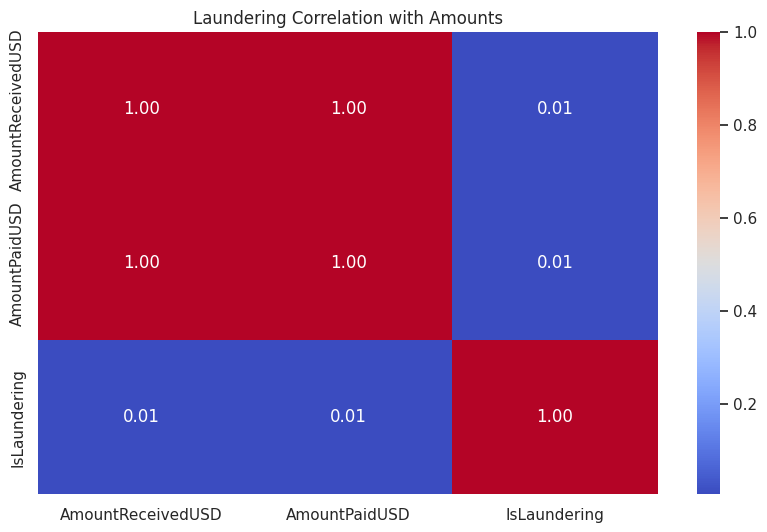

In [22]:

# 1. Select relevant columns from the DataFrame
corr_df = df.select("AmountReceivedUSD", "AmountPaidUSD", "IsLaundering")

# 2. Convert the Spark DataFrame to Pandas
corr_pd = corr_df.toPandas()

# 3. Calculate the correlation using Pandas
corr_matrix = corr_pd.corr()

# 4. Visualize using Seaborn
plt.figure(figsize=(10, 6))

# Plot using Seaborn
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")

# Customize the plot
plt.title('Laundering Correlation with Amounts')
plt.show()


### 1.8 What is the frequency of transaction formats?

+-------------+-----+
|PaymentFormat|count|
+-------------+-----+
|          ACH| 4483|
|       Cheque|  324|
|  Credit Card|  206|
|         Cash|  108|
|      Bitcoin|   56|
+-------------+-----+



/tmp/ipykernel_1456/4081189733.py:22: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="PaymentFormat", y="count", data=result_df.toPandas(), palette="muted")


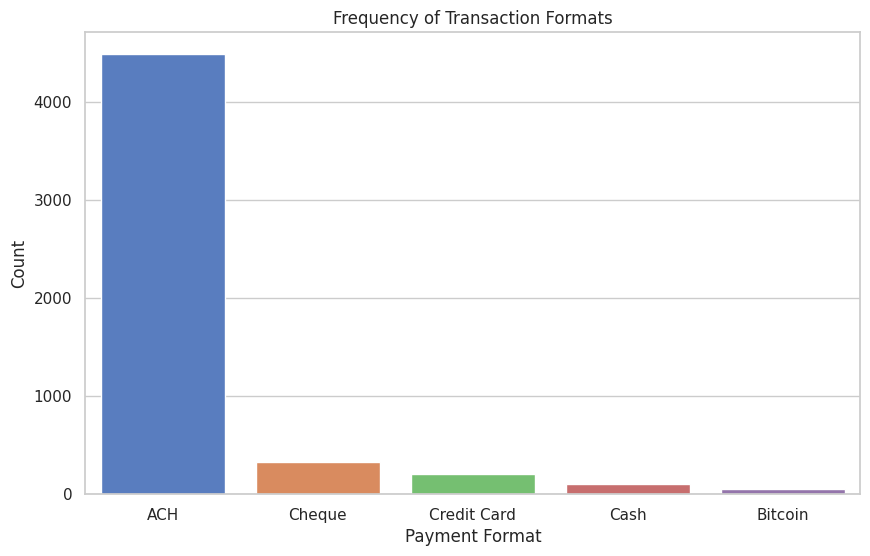

In [21]:

# 1. Register DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

# 2. Query to get the frequency of transaction formats
query = """
    SELECT PaymentFormat, COUNT(*) as count
    FROM transactions
    WHERE IsLaundering = 1
    GROUP BY PaymentFormat
    ORDER BY count DESC
"""

result_df = spark.sql(query)

# 3. Show the result
result_df.show()

# 4. Visualize using Seaborn
plt.figure(figsize=(10, 6))

# Plot using Seaborn
ax = sns.barplot(x="PaymentFormat", y="count", data=result_df.toPandas(), palette="muted")

# Customize the plot
ax.set(xlabel="Payment Format", ylabel="Count", title="Frequency of Transaction Formats")
plt.show()
